# Qualitative QC analysis of counts in each sample
This Python Jupyter notebook performs a qualitative analysis of the counts for the variants in each sample.
It then computes functional scores for each variant.
These are heuristic functional scores based on overall enrichment, not the more detailed bin-based scores generated elsewhere.

## Set up analysis

### Import Python modules.
This notebook primarily makes use of the Bloom lab's [dms_variants](https://jbloomlab.github.io/dms_variants) package, and uses [plotnine](https://github.com/has2k1/plotnine) for ggplot2-like plotting syntax:

In [1]:
import collections
import os
import warnings

import alignparse.targets

import dms_variants.codonvarianttable
from dms_variants.constants import CBPALETTE
import dms_variants.plotnine_themes

from IPython.display import display, HTML, Image

import numpy

import pandas as pd

from plotnine import *

import yaml

Set [plotnine](https://github.com/has2k1/plotnine) theme to the gray-grid one defined in [dms_variants](https://jbloomlab.github.io/dms_variants):

In [2]:
theme_set(dms_variants.plotnine_themes.theme_graygrid())

Versions of key software:

In [3]:
print(f"Using dms_variants version {dms_variants.__version__}")
print(f"Using alignparse version {alignparse.__version__}")

Using dms_variants version 0.6.0
Using alignparse version 0.1.3


Ignore warnings that clutter output:

In [4]:
warnings.simplefilter('ignore')

### Parameters for notebook
Read the configuration file:

In [5]:
with open('config.yaml') as f:
    config = yaml.safe_load(f)

Make output directory if needed:

In [6]:
os.makedirs(config['counts_dir'], exist_ok=True)
os.makedirs(config['figs_dir'], exist_ok=True)
os.makedirs(config['func_scores_dir'], exist_ok=True)

Read information about the samples:

In [7]:
sample_info = pd.read_csv(config['barcode_runs'])

Get lists of the *SortSeq* and *TiteSeq* samples:

In [8]:
sortseq_samples = sample_info.query('sample_type == "SortSeq"')['sample'].unique().tolist()
titeseq_samples = sample_info.query('sample_type == "TiteSeq"')['sample'].unique().tolist()

## Initialize codon-variant table
Initialize [CodonVariantTable](https://jbloomlab.github.io/dms_variants/dms_variants.codonvarianttable.html#dms_variants.codonvarianttable.CodonVariantTable) from wildtype gene sequence and the variant counts CSV file.
We will then use the plotting functions of this variant table to analyze the counts per sample:

In [9]:
# get wildtype gene sequence for primary target
targets = alignparse.targets.Targets(
                seqsfile=config['amplicons'],
                feature_parse_specs=config['feature_parse_specs'])
geneseq = targets.get_target(config['primary_target']).get_feature('gene').seq
print(f"Read gene of {len(geneseq)} nts for {config['primary_target']} from {config['amplicons']}")
      
print('Initializing CodonVariantTable from gene sequence and ' +
      config['variant_counts_file'])
      
variants = dms_variants.codonvarianttable.CodonVariantTable.from_variant_count_df(
                geneseq=geneseq,
                variant_count_df_file=config['variant_counts_file'],
                primary_target=config['primary_target'])
      
print('Done initializing CodonVariantTable.')

Read gene of 603 nts for SARS-CoV-2 from data/PacBio_amplicons.gb
Initializing CodonVariantTable from gene sequence and results/counts/variant_counts.csv
Done initializing CodonVariantTable.


## Analyze counts for samples
Analyze the variant counts per cell for each sample:

In [10]:
counts = (
    variants.variant_count_df
    .groupby(['library', 'sample'])
    .aggregate({'count': 'sum'})
    .merge(sample_info, on=['library', 'sample'], validate='one_to_one')
    .merge(variants.n_variants_df(samples=None)
                   .groupby('library')
                   .aggregate(n_variants=pd.NamedAgg('count', 'sum')),
           on='library', validate='many_to_one')
    .assign(counts_per_cell=lambda x: x['count'] / x['number_cells'])
    .drop(columns=['R1', 'date'])
    )

counts.head()

,library,sample,count,sample_type,sort_bin,concentration,number_cells,n_variants,counts_per_cell
0,lib1,SortSeq_bin1,22911930,SortSeq,1,NaN,6600000,99648,3.471505
1,lib1,SortSeq_bin2,11262091,SortSeq,2,NaN,3060000,99648,3.680422
2,lib1,SortSeq_bin3,9598488,SortSeq,3,NaN,2511000,99648,3.822576
3,lib1,SortSeq_bin4,11220871,SortSeq,4,NaN,2992000,99648,3.750291
4,lib1,TiteSeq_01_bin1,2700607,TiteSeq,1,1.0,1098088,99648,2.459372


For the *SortSeq* arm plot the average counts per variant, the average cells per variant, and the average counts per cell for each library / sample:

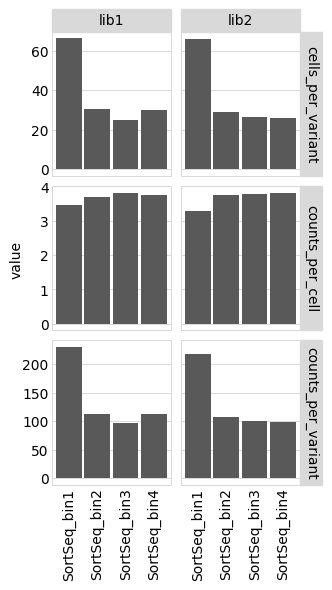

In [11]:
p = (
    ggplot(counts.query('sample in @sortseq_samples')
                 .assign(counts_per_variant=lambda x: x['count'] / x['n_variants'],
                         cells_per_variant=lambda x: x['number_cells'] / x['n_variants'])
                 .melt(id_vars=['library', 'sample'],
                       value_vars=['counts_per_variant', 'cells_per_variant', 'counts_per_cell'],
                       var_name='statistic'),
           aes('sample', 'value')) +
    geom_bar(stat='identity') +
    facet_grid('statistic ~ library', scales='free_y') +
    theme(axis_text_x=element_text(angle=90),
          figure_size=(0.4 * len(sortseq_samples) * counts['library'].nunique(), 6),
          panel_grid_major_x=element_blank()) +
    xlab('')
    )

_ = p.draw()

For the *TiteSeq* arm, plot cells per variant aggregated across all bins for each concentration:

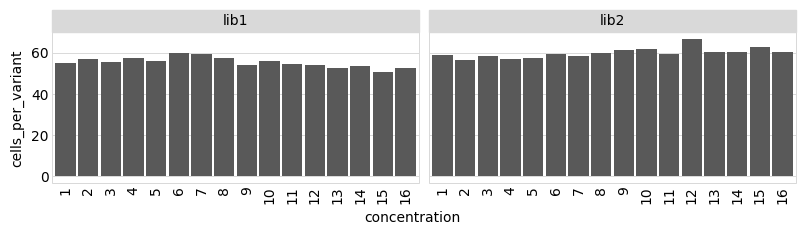

In [12]:
p = (
    ggplot(counts.query('sample in @titeseq_samples')
                 .groupby(['library', 'concentration', 'n_variants'])
                 .aggregate({'number_cells': 'sum'})
                 .reset_index()
                 .assign(cells_per_variant=lambda x: x['number_cells'] / x['n_variants'],
                         concentration=lambda x: pd.Categorical(x['concentration'].astype(int))),
           aes('concentration', 'cells_per_variant')) +
    geom_bar(stat='identity') +
    facet_grid('~ library', scales='nrow') +
    theme(axis_text_x=element_text(angle=90),
          figure_size=(0.3 * counts['concentration'].nunique() * counts['library'].nunique(), 2),
          panel_grid_major_x=element_blank())
    )

_ = p.draw()

Also for the *TiteSeq* arm, plot counts per cell for each sample (bin and concentration):

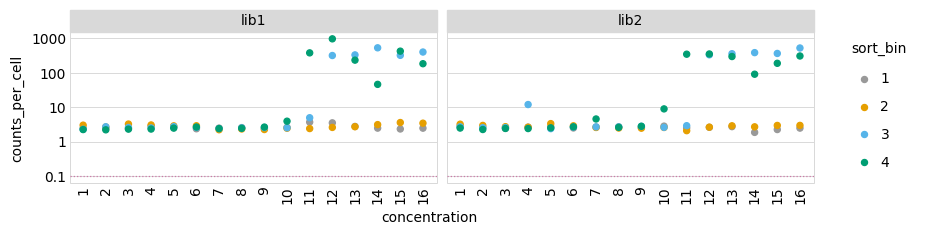

In [13]:
lower_limit = 0.1  # plot values less than this as this

p = (
    ggplot(counts.query('sample in @titeseq_samples')
                 .assign(sort_bin=lambda x: pd.Categorical(x['sort_bin']),
                         concentration=lambda x: pd.Categorical(x['concentration'].astype(int)),
                         counts_per_cell=lambda x: numpy.clip(x['counts_per_cell'],
                                                              lower_limit, None)
                         ),
           aes('concentration', 'counts_per_cell', color='sort_bin')) +
    geom_point(size=2) +
    facet_wrap('~ library') +
    scale_color_manual(values=CBPALETTE) +
    scale_y_log10() +
    geom_hline(yintercept=lower_limit, color=CBPALETTE[-1], linetype='dotted') +
    theme(axis_text_x=element_text(angle=90),
          figure_size=(0.3 * counts['concentration'].nunique() * counts['library'].nunique(), 2),
          panel_grid_major_x=element_blank()
          )
    )

_ = p.draw()

## Mutations per variant
Average number of mutations per gene among all variants of the primary target for *SortSeq* samples:

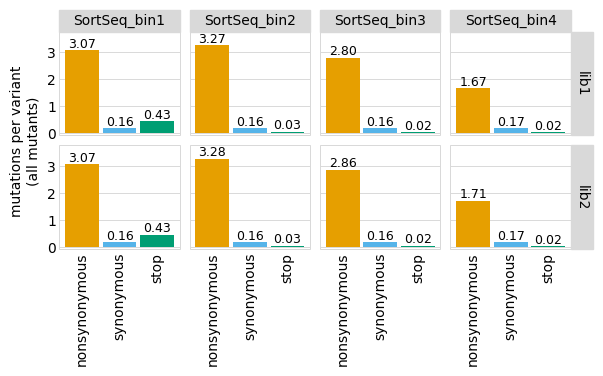

In [14]:
p = variants.plotNumCodonMutsByType(variant_type='all',
                                    orientation='v',
                                    libraries=variants.libraries,
                                    samples=sortseq_samples,
                                    heightscale=0.8)
p = p + theme(panel_grid_major_x=element_blank())  # no vertical grid lines
_ = p.draw()

Mutation frequency across gene among all variants for primary target for *SortSeq* samples only:

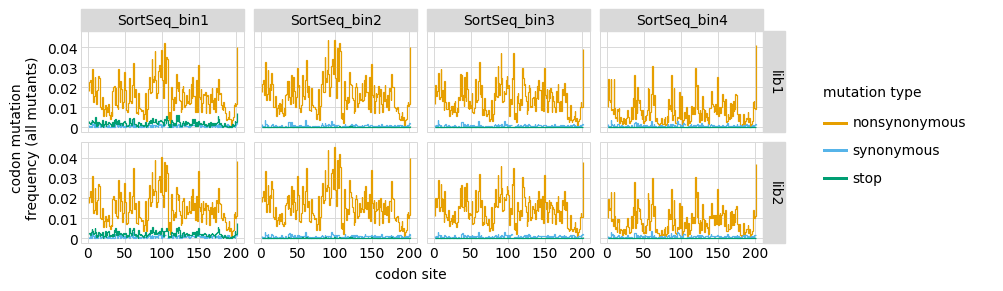

In [15]:
p = variants.plotMutFreqs('all',
                          'codon',
                          orientation='v',
                          libraries=variants.libraries,
                          samples=sortseq_samples)
_ = p.draw()

Now plot the average mutation frequency for the *TiteSeq* samples.
To make the plot not too big, chunk the plots out for smaller subsets:

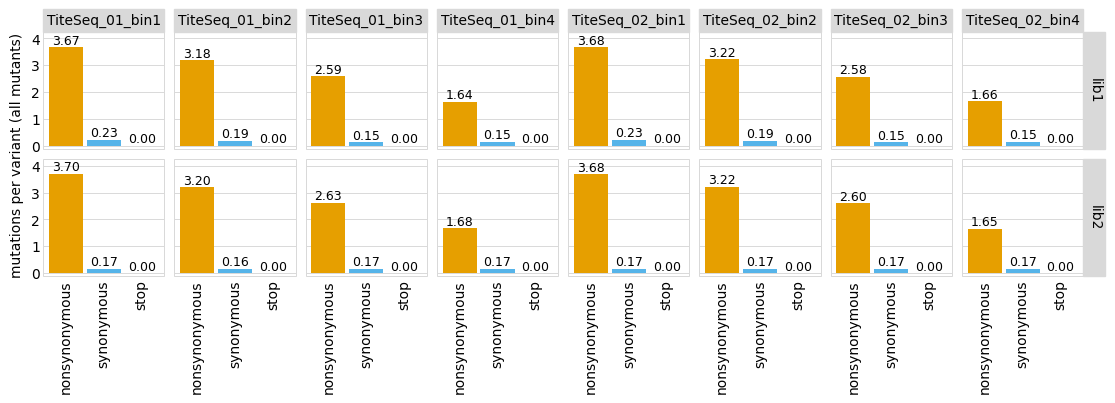

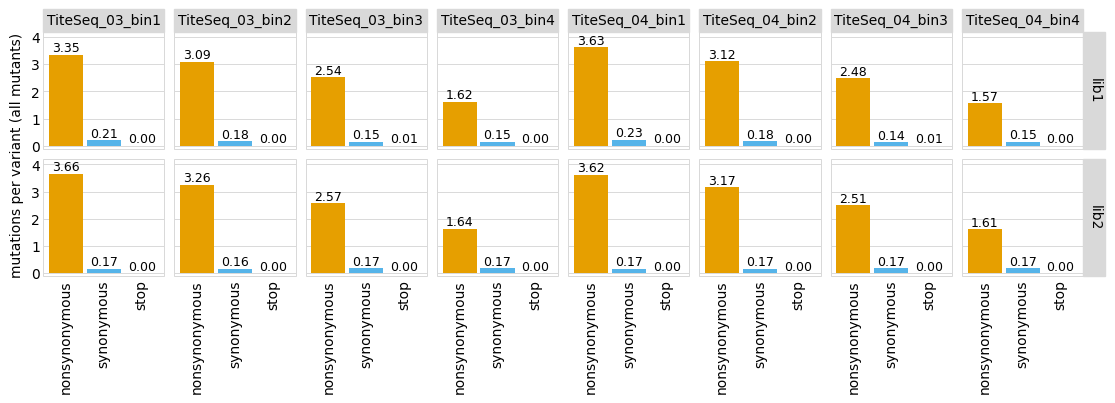

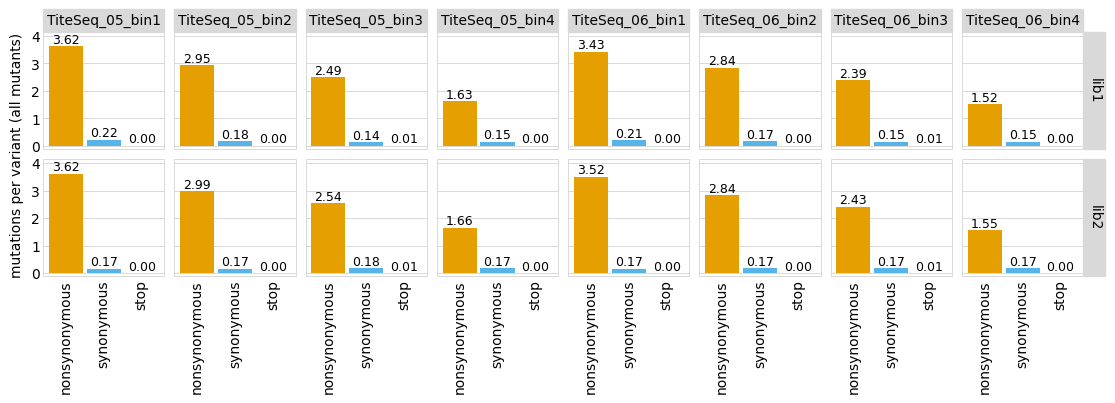

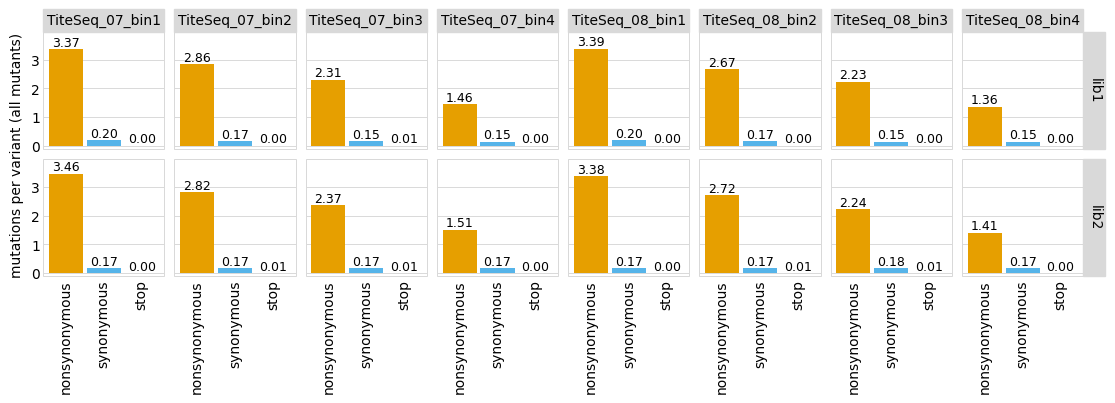

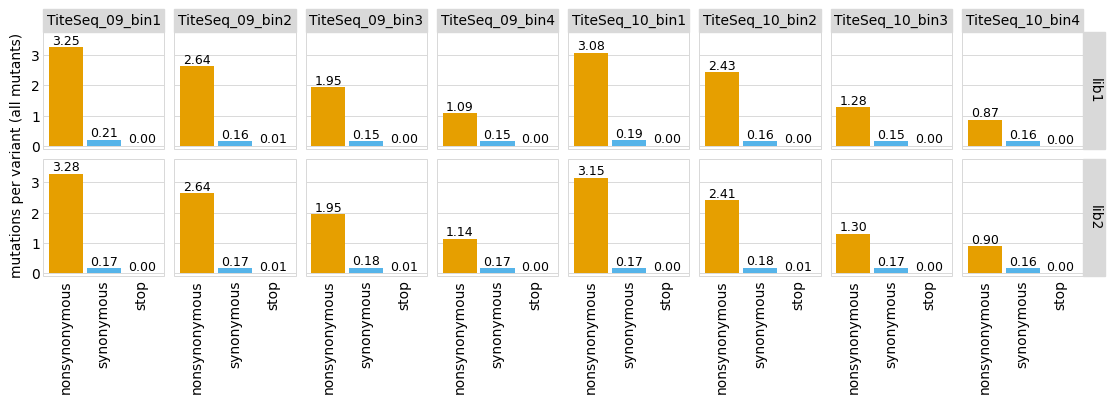

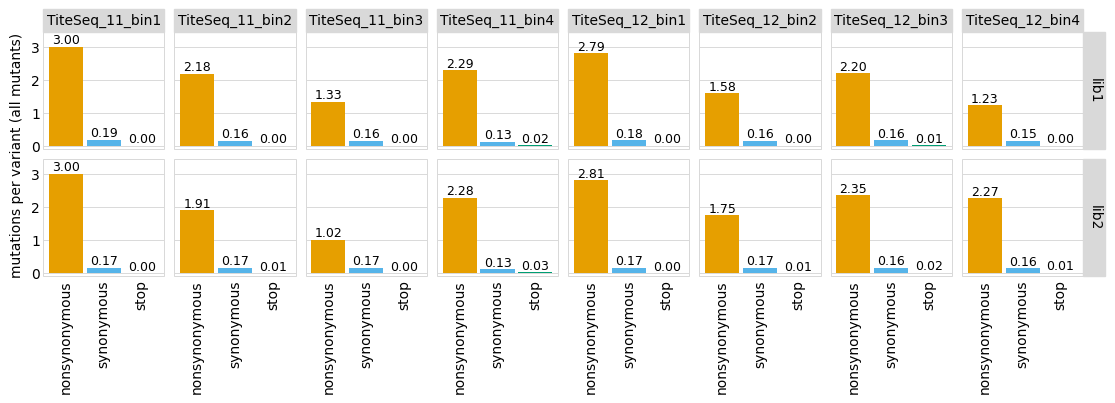

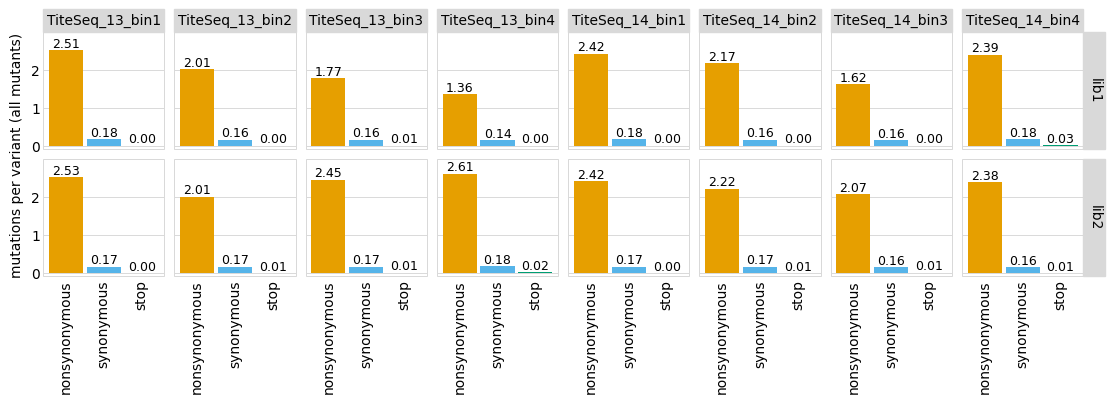

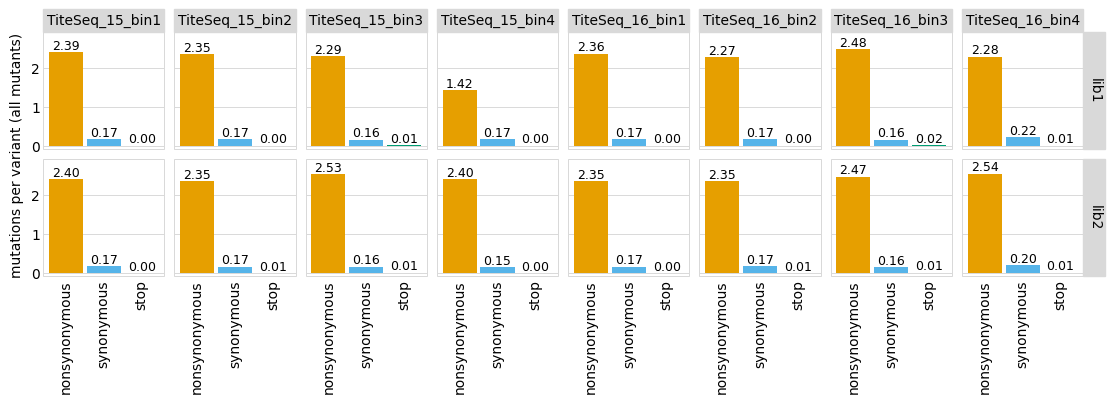

In [16]:
i = 0
chunksize = 8

while i < len(titeseq_samples):
    p = variants.plotNumCodonMutsByType(
                                    variant_type='all',
                                    orientation='v',
                                    libraries=variants.libraries,
                                    samples=titeseq_samples[i: i + chunksize],
                                    heightscale=0.9,
                                    widthscale=1.1)
    p = p + theme(panel_grid_major_x=element_blank())  # no vertical grid lines
    _ = p.draw()
    i += chunksize